In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# define training settings
NUM_EPOCHS = 150
BATCH_SIZE = 128
MULTIPLIER = 1.0

In [3]:
import torch

CUDA_DEVICE = 2

torch.cuda.set_device(CUDA_DEVICE)
device = torch.device(f"cuda:{CUDA_DEVICE}" if torch.cuda.is_available() else "cpu")

In [4]:
from doren_bnn.mobilenet import MobileNet, NetType
from torchinfo import summary

NETTYPE = NetType.XNORPP_STTN
model = MobileNet(3, num_classes=10, nettype=NETTYPE, learnable=True).to(device)

summary(model, input_size=(BATCH_SIZE, 3, 32, 32))

Layer (type:depth-idx)                             Output Shape              Param #
MobileNet                                          [128, 10]                 --
├─Upsample: 1-1                                    [128, 3, 224, 224]        --
├─Sequential: 1-2                                  [128, 1024, 1, 1]         --
│    └─MobileNet_ConvBlock: 2-1                    [128, 32, 112, 112]       --
│    │    └─Sequential: 3-1                        [128, 32, 112, 112]       1,766
│    └─MobileNet_ConvDsBlock: 2-2                  [128, 64, 112, 112]       --
│    │    └─Sequential: 3-2                        [128, 64, 112, 112]       4,896
│    └─MobileNet_ConvDsBlock: 2-3                  [128, 128, 56, 56]        --
│    │    └─Sequential: 3-3                        [128, 128, 56, 56]        17,984
│    └─MobileNet_ConvDsBlock: 2-4                  [128, 128, 56, 56]        --
│    │    └─Sequential: 3-4                        [128, 128, 56, 56]        35,840
│    └─MobileNet_Conv

In [5]:
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW

# from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.optim.lr_scheduler import CosineAnnealingLR

criterion = CrossEntropyLoss().to(device)
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=5e-6)
# scheduler = CosineAnnealingWarmRestarts(optimizer, 50)
scheduler = CosineAnnealingLR(optimizer, NUM_EPOCHS)

In [6]:
from doren_bnn.utils import Dataset, Experiment

EXPERIMENT_ID = f"mobilenet-xnorpp-sttn-learnable-cifar10-{MULTIPLIER}x"
print(EXPERIMENT_ID)
experiment = Experiment(
    EXPERIMENT_ID, Dataset.CIFAR10, BATCH_SIZE, multiplier=MULTIPLIER
)

mobilenet-xnorpp-sttn-learnable-cifar10-1.0x
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# uncomment if you wish to load a previous checkpoint
experiment.load_checkpoint(model, optimizer, scheduler)

# Training

In [8]:
experiment.train(
    model,
    criterion,
    optimizer,
    scheduler,
    NUM_EPOCHS,
    device=device,
)

100%|##########| 150/150 [00:00<?, ?it/s]

# Test-time Inference

In [9]:
from doren_bnn.mobilenet import MobileNet, NetType
from torchinfo import summary

NETTYPE = NetType.XNORPP_STTN
model = MobileNet(3, num_classes=10, nettype=NETTYPE, learnable=True).to(device)

summary(model, input_size=(BATCH_SIZE, 3, 32, 32))

Layer (type:depth-idx)                             Output Shape              Param #
MobileNet                                          [128, 10]                 --
├─Upsample: 1-1                                    [128, 3, 224, 224]        --
├─Sequential: 1-2                                  [128, 1024, 1, 1]         --
│    └─MobileNet_ConvBlock: 2-1                    [128, 32, 112, 112]       --
│    │    └─Sequential: 3-1                        [128, 32, 112, 112]       1,766
│    └─MobileNet_ConvDsBlock: 2-2                  [128, 64, 112, 112]       --
│    │    └─Sequential: 3-2                        [128, 64, 112, 112]       4,896
│    └─MobileNet_ConvDsBlock: 2-3                  [128, 128, 56, 56]        --
│    │    └─Sequential: 3-3                        [128, 128, 56, 56]        17,984
│    └─MobileNet_ConvDsBlock: 2-4                  [128, 128, 56, 56]        --
│    │    └─Sequential: 3-4                        [128, 128, 56, 56]        35,840
│    └─MobileNet_Conv

In [ ]:
experiment.load_checkpoint(model, optimizer, scheduler)

In [11]:
experiment.test(model, device=device)

In [12]:
from doren_bnn.xnorpp_sttn import Conv2d_XnorPP_STTN

sparsity = []
for i, module in enumerate(
    filter(lambda m: isinstance(m, Conv2d_XnorPP_STTN), model.modules())
):
    print(module.in_channels, module.out_channels, module.kernel_size)
    weight_ter = module._get_weight_ter()
    print(weight_ter.size())

    total_num_sparse = 0
    max_num_nonsparse = -1
    for row in weight_ter:
        num_sparse = (row == 0).sum().item()
        num_nonsparse = row.numel() - num_sparse

        total_num_sparse += num_sparse
        if num_nonsparse > max_num_nonsparse:
            max_num_nonsparse = num_nonsparse

    print(max_num_nonsparse)
    print(total_num_sparse / weight_ter.numel())
    print("---")

    sparsity.append((i, total_num_sparse / weight_ter.numel(), module.kernel_size))

3 32 3
torch.Size([32, 3, 3, 3])
20
0.45949074074074076
---
32 32 3
torch.Size([32, 1, 3, 3])
6
0.4826388888888889
---
32 64 1
torch.Size([64, 32, 1, 1])
26
0.44384765625
---
64 64 3
torch.Size([64, 1, 3, 3])
8
0.4635416666666667
---
64 128 1
torch.Size([128, 64, 1, 1])
53
0.387451171875
---
128 128 3
torch.Size([128, 1, 3, 3])
9
0.4487847222222222
---
128 128 1
torch.Size([128, 128, 1, 1])
109
0.32830810546875
---
128 128 3
torch.Size([128, 1, 3, 3])
9
0.4210069444444444
---
128 256 1
torch.Size([256, 128, 1, 1])
111
0.285552978515625
---
256 256 3
torch.Size([256, 1, 3, 3])
9
0.4444444444444444
---
256 256 1
torch.Size([256, 256, 1, 1])
230
0.253448486328125
---
256 256 3
torch.Size([256, 1, 3, 3])
9
0.4114583333333333
---
256 512 1
torch.Size([512, 256, 1, 1])
231
0.2067413330078125
---
512 512 3
torch.Size([512, 1, 3, 3])
9
0.4225260416666667
---
512 512 1
torch.Size([512, 512, 1, 1])
474
0.20558547973632812
---
512 512 3
torch.Size([512, 1, 3, 3])
9
0.4294704861111111
---
512 512 

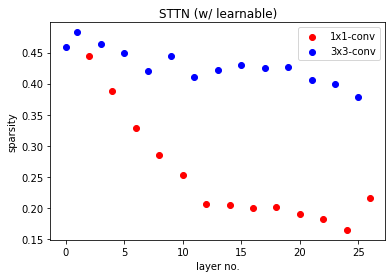

In [13]:
import matplotlib.pyplot as plt

ids_1 = [i for (i, _, k) in sparsity if k == 1]
vals_1 = [val for (_, val, k) in sparsity if k == 1]
plt.scatter(ids_1, vals_1, c="red", label="1x1-conv")

ids_3 = [i for (i, _, k) in sparsity if k == 3]
vals_3 = [val for (_, val, k) in sparsity if k == 3]
plt.scatter(ids_3, vals_3, c="blue", label="3x3-conv")

plt.title("STTN (w/ learnable)")
plt.xlabel("layer no.")
plt.ylabel("sparsity")
plt.legend()